# Imports

In [1]:
import sys
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import aifeynman
import scipy
from scipy.stats import kde
import h5py

# Clases

In [ ]:
class Galaxy:
    def __init__(self, M, SM, SFR, log=False):
        if not log:
            self.M = M
            self.SM = SM
            self.SFR = SFR
        else:
            self.M = math.log10(M)
            self.SM = math.log10(SM)
            self.SFR = math.log10(SFR+0.00000000001)
        
    def __repr__(self):
        return f"<Galaxy M:{self.M} SM:{self.SM} SFR:{self.SFR}>"

In [ ]:
class Redshift:
    def __init__(self, path, Ngalaxies=-1, load=True, log=False):
        self.h = h5py.File(path, 'r')
        
        self.Box = int(self.h.attrs["Box"])
        if Ngalaxies >= 0:
            self.Ngalaxies = min(int(self.h.attrs["Ngalaxies"]), Ngalaxies)
        else:
            self.Ngalaxies = int(self.h.attrs["Ngalaxies"])
        self.Redshift = self.h.attrs["Redshift"]
        
        self.galaxies = []
        
        if load:
            self.load_galaxies(log)
    
    def load_galaxies(self, log=False):
        M = np.real(self.h.get('Mvir'))
        SM = np.real(self.h.get('StellarMass'))
        SFR = np.real(self.h.get('StarFormationRate'))
        
        self.galaxies = []

        for i in trange(self.Ngalaxies):
            if SFR[i] == 0: continue
            g = Galaxy(M[i], SM[i], SFR[i], log)
            self.galaxies.append(g)

        self.Ngalaxies = len(self.galaxies)
        
    def __repr__(self):
        return f"<Redshift Box:{self.Box} Ngalaxies:{self.Ngalaxies} Redshift:{self.Redshift}>"

# Procesamiento de Datos

## Rutas

In [3]:
ROOT = sys.prefix[:-4]
DATA_DIR = ROOT + 'data/Uchuu-UM/'

FILES = [
            'Sample.01.Redshift.0.000.h5',
            'Sample.01.Redshift.1.032.h5',
            'Sample.01.Redshift.2.029.h5',
            'Sample.01.Redshift.3.129.h5',
            'Sample.01.Redshift.4.269.h5',
            'Sample.01.Redshift.5.155.h5'
        ]

PATHS = [DATA_DIR + f for f in FILES]

## Constantes

In [53]:
# Constantes de selección de datos
Z = 0
N_GALAXIES = -1

# Constantes de M_halo frente a M_*
STEP = 0.05

# Constantes de la distribución de probabilidad
DISTRIBUTION_CENTERS = [8.5, 9.0, 9.5, 10.0]
DISTRIBUTION_WIDTH = 0.05
DISTRIBUTION_BINS = 750
DISTRIBUTION_COLORS = ['blue', 'red', 'orange', 'green']

# Constantes de M_halo frente a M_* y SFR
SM_BINS = 750
SFR_BINS = 750

## Cargar Redshift

In [54]:
redshift = Redshift(PATHS[Z], Ngalaxies=N_GALAXIES, log=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [55]:
SM = [g.SM for g in redshift.galaxies]
SFR = [g.SFR for g in redshift.galaxies]
M = [g.M for g in redshift.galaxies]

# Masa del Halo de Materia Oscura frente a Masa Estelar

## Función de las Medianas de la Masa del Halo de Materia Oscura

### Mapa de Densidad

<IPython.core.display.Javascript object>


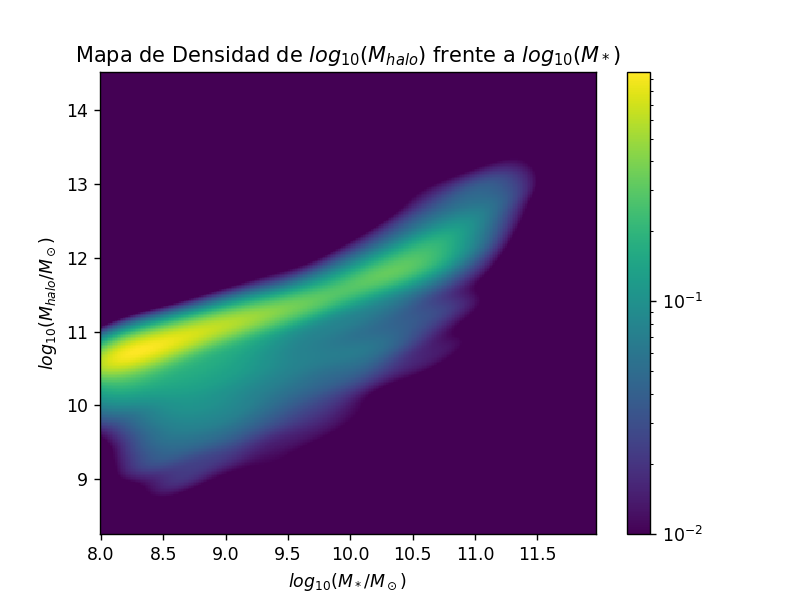

In [7]:
%matplotlib notebook

X = np.array(SM)
y = np.array(M)

nbins=300
k = kde.gaussian_kde([X,y])
xi, yi = np.mgrid[X.min():X.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.title("Mapa de Densidad de $log_{10}(M_{halo})$ frente a $log_{10}(M_*)$")
plt.xlabel(r"$log_{10}(M_*/M_\odot)$")
plt.ylabel(r"$log_{10}(M_{halo}/M_\odot)$")

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', norm=matplotlib.colors.LogNorm(vmin=10**(-2), vmax=zi.max()))
plt.colorbar()
plt.show()

### Agrupación en Intervalos

In [48]:
def median_galaxy(gs):
    SM = STEP*(gs[0].SM//STEP)+STEP/2
    
    M = 0
    if len(gs) % 2 == 0:
        M = (gs[len(gs)//2-1].M+gs[len(gs)//2].M)/2
    else:
        M = gs[len(gs)//2].M
    
    return Galaxy(M, SM, 0)

In [49]:
redshift.galaxies.sort(key=lambda x: x.SM)

r = Redshift(PATHS[0], False)

curr = 0
tmp = []
for g in redshift.galaxies:
    region = g.SM//STEP
    
    if curr == region:
        tmp.append(g)
    else:
        if len(tmp):
            r.galaxies.append(median_galaxy(tmp))
        curr = region
        tmp = [g]
        
if len(tmp):
    r.galaxies.append(median_galaxy(tmp))
    
r.Ngalaxies = len(r.galaxies)

SM = [g.SM for g in r.galaxies]
M = [g.M for g in r.galaxies]

0it [00:00, ?it/s]

### Gráficas con Intervalos

<IPython.core.display.Javascript object>


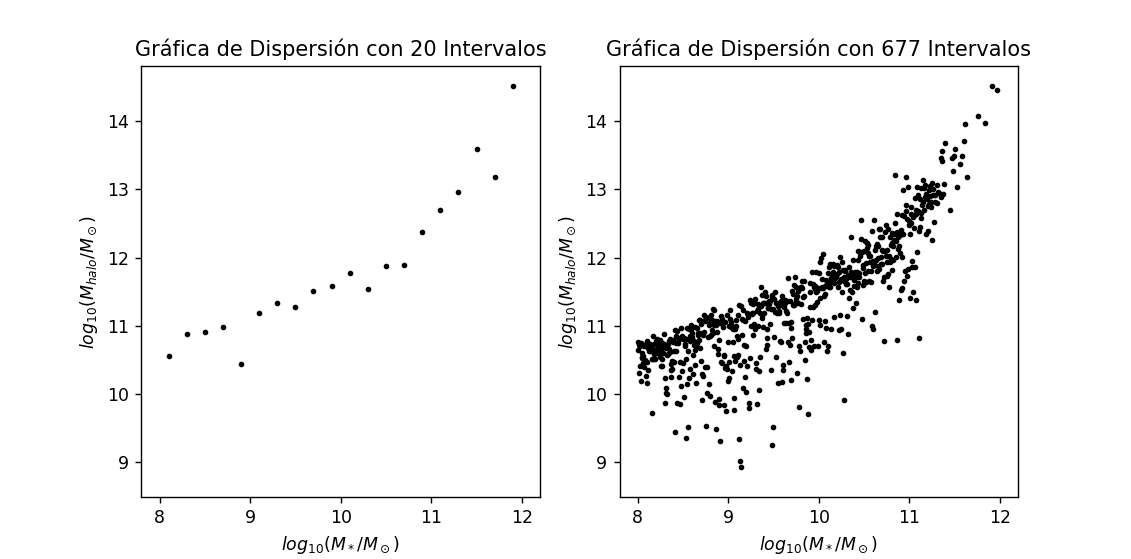

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [68]:
%matplotlib notebook

fig, axs = plt.subplots(1, 2)

STEPS = [0.2, 0.005]

for i in range(2):
    STEP = STEPS[i]
    r = Redshift(PATHS[0], False)

    curr = 0
    tmp = []
    for g in redshift.galaxies:
        region = g.SM//STEP

        if curr == region:
            tmp.append(g)
        else:
            if len(tmp):
                r.galaxies.append(median_galaxy(tmp))
            curr = region
            tmp = [g]
        
    if len(tmp):
        r.galaxies.append(median_galaxy(tmp))

    r.Ngalaxies = len(r.galaxies)
    
    SM = [g.SM for g in r.galaxies]
    M = [g.M for g in r.galaxies]
    
    axs[i].set_title(f"Gráfica de Dispersión con {len(SM)} Intervalos")
    axs[i].set(xlabel=r"$log_{10}(M_*/M_\odot)$", ylabel=r"$log_{10}(M_{halo}/M_\odot)$")
    
    axs[i].set_xlim([7.8, 12.2])
    axs[i].set_ylim([8.5, 14.8])

    axs[i].scatter(SM, M, s=5, c ='black')

<IPython.core.display.Javascript object>


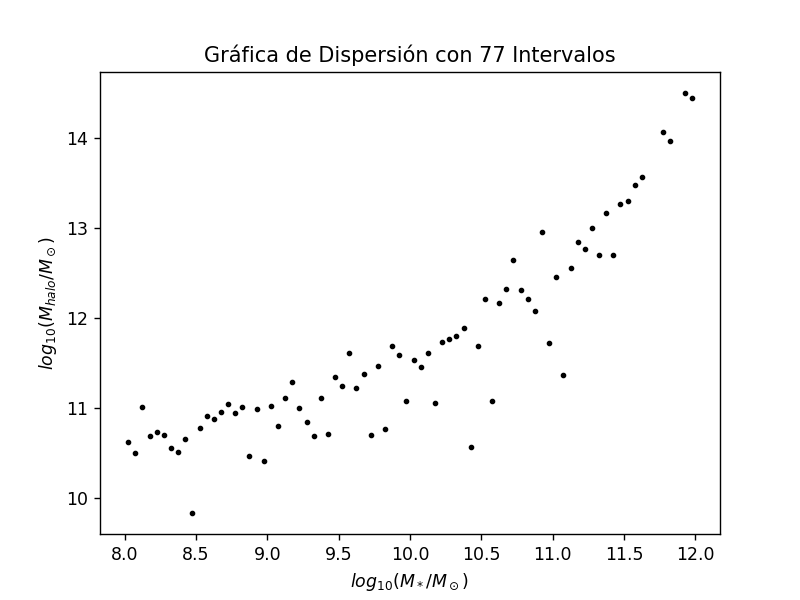

In [63]:
%matplotlib notebook
    
plt.title(f"Gráfica de Dispersión con {len(SM)} Intervalos")
plt.xlabel(r"$log_{10}(M_*/M_\odot)$")
plt.ylabel(r"$log_{10}(M_{halo}/M_\odot)$")

plt.scatter(SM, M, s=5, c ='black')

### *AI-Feynman*

In [ ]:
with open(f"data/redshift{Z}.txt", "w") as f:
    for g in r.galaxies:
        f.write(f"{g.SM} {g.M}\n")

In [ ]:
aifeynman.run_aifeynman("./data/", f"redshift{0}.txt", 7200, ROOT+"aifeynman/ops.txt", polyfit_deg=4, NN_epochs=4000)

<IPython.core.display.Javascript object>


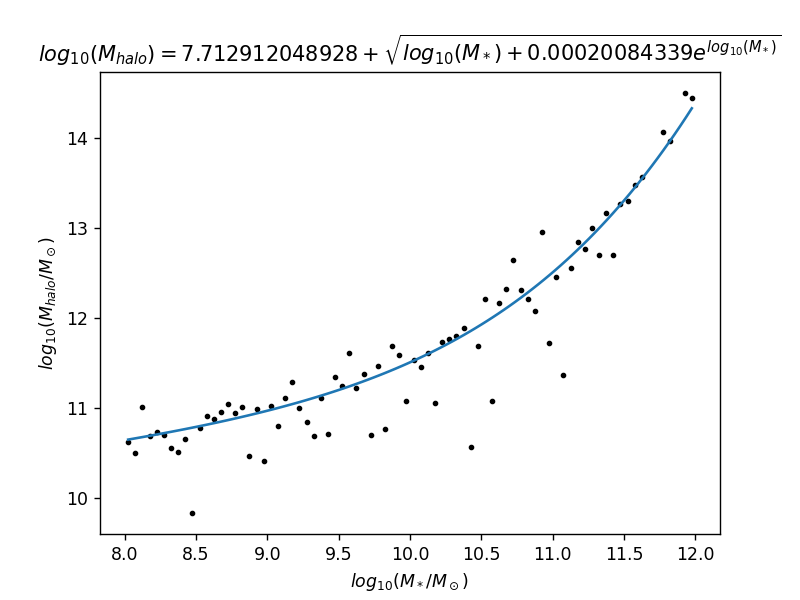

[Text(0.5, 0, '$log_{10}(M_*/M_\\odot)$'),
 Text(0, 0.5, '$log_{10}(M_{halo}/M_\\odot)$')]

In [97]:
%matplotlib notebook

ax = plt.subplot()

x = np.linspace(min(SM), max(SM), 100)
y = 7.712912048928+np.sqrt((x+0.00020084339*np.exp(x)))

ax.scatter(SM, M, s=5, c ='black')
ax.set_title("$log_{10}(M_{halo}) = 7.712912048928+\sqrt{log_{10}(M_*)+0.00020084339e^{log_{10}(M_*)}}$")
ax.plot(x, y)
ax.set(xlabel='$log_{10}(M_*/M_\odot)$', ylabel='$log_{10}(M_{halo}/M_\odot)$') # RMS Error barras

## Función de Densidad de Probabilidad

### Utilidades

In [56]:
def normalized_distribution(var, bins):
    distribution_counts, distribution_bins = np.histogram(var, bins, density=True)
    bin_width = distribution_bins[1]-distribution_bins[0]

    X = np.array([])
    y = distribution_counts*bin_width
    for j in range(len(distribution_counts)):
            X = np.append(X, (distribution_bins[j+1]+distribution_bins[j])/2)
    
    return X, y, bin_width

### Gráficas con Intervalos

<IPython.core.display.Javascript object>


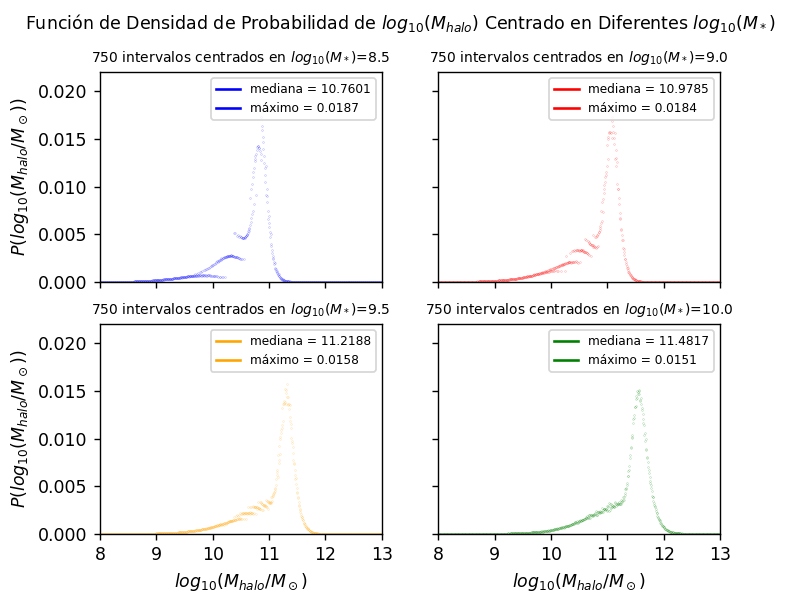

In [101]:
%matplotlib notebook

fig, axs = plt.subplots(2, 2)
fig.suptitle("Función de Densidad de Probabilidad de $log_{10}(M_{halo})$ Centrado en Diferentes $log_{10}(M_*)$", size=10)

redshift.galaxies.sort(key=lambda x: x.SM)

for i, ax in enumerate(axs.flat):
    ax.set_title(f'{DISTRIBUTION_BINS} intervalos centrados en $log_{{{10}}}(M_*)$={DISTRIBUTION_CENTERS[i]}', fontsize=8)
    ax.set_xlim(8, 13)
    ax.set_ylim(0, 0.022)
    ax.set(xlabel='$log_{10}(M_{halo}/M_\odot)$', ylabel='$P(log_{10}(M_{halo}/M_\odot))$')
    
    var = []
    for g in redshift.galaxies:
        if g.SM >= DISTRIBUTION_CENTERS[i]-DISTRIBUTION_WIDTH and g.SM <= DISTRIBUTION_CENTERS[i]+DISTRIBUTION_WIDTH:
            var.append(g.M)

    X, y, bin_width = normalized_distribution(var, DISTRIBUTION_BINS)
    
    ax.scatter(X, y, bin_width, color=DISTRIBUTION_COLORS[i])
    
    median = np.median(var)
    mx = np.max(y)
    ax.plot([], [], color=DISTRIBUTION_COLORS[i], label=f"mediana = {median:.4f}")
    ax.plot([], [], color=DISTRIBUTION_COLORS[i], label=f"máximo = {mx:.4f}")
    ax.legend(loc="upper right", fontsize=7)

for ax in axs.flat:
    ax.label_outer()

plt.show()

### *AI-Feynman*

In [63]:
K = 100000

for i in range(len(DISTRIBUTION_CENTERS)):
    var = []
    for g in redshift.galaxies:
        if g.SM >= DISTRIBUTION_CENTERS[i]-DISTRIBUTION_WIDTH and g.SM <= DISTRIBUTION_CENTERS[i]+DISTRIBUTION_WIDTH:
            var.append(g.M)

    X, y, bin_width = normalized_distribution(var, DISTRIBUTION_BINS)
    y *= K
    median = np.median(var)
    mx = np.max(y)
    
    mode = "w" if i == 0 else "a"
    with open(f"data/redshift{Z}.txt", mode) as f:
        for i in range(len(X)):
            f.write(f"{X[i]} {median} {mx} {y[i]}\n")

In [ ]:
aifeynman.run_aifeynman("./data/", f"redshift{Z}.txt", 21600, ROOT+"aifeynman/ops.txt", polyfit_deg=3, NN_epochs=4000)

<IPython.core.display.Javascript object>


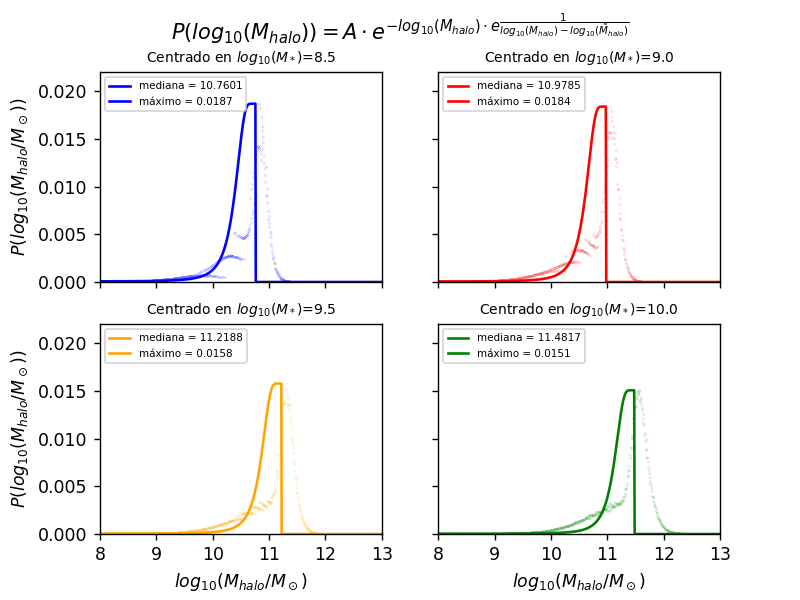

In [90]:
%matplotlib notebook

fig, axs = plt.subplots(2, 2)
fig.suptitle("$P(log_{10}(M_{halo}))=A\cdot e^{-log_{10}(M_{halo})\cdot e^{\dfrac{1}{log_{10}(M_{halo})-log_{10}(\\tilde{M}_{halo})}}}$")
#fig.suptitle("$A\cdot e^{-log_{10}(M_{halo})\cdot e^{\frac{1}{log_{10}(M_{halo})-log_{10}(\tilde{M}_{halo})}}}$", size=10)

redshift.galaxies.sort(key=lambda x: x.SM)

for i, ax in enumerate(axs.flat):
    ax.set_title(f'Centrado en $log_{{{10}}}(M_*)$={DISTRIBUTION_CENTERS[i]}', fontsize=8)
    ax.set_xlim(8, 13)
    ax.set_ylim(0, 0.022)
    ax.set(xlabel='$log_{10}(M_{halo}/M_\odot)$', ylabel='$P(log_{10}(M_{halo}/M_\odot))$')
    
    var = []
    for g in redshift.galaxies:
        if g.SM >= DISTRIBUTION_CENTERS[i]-DISTRIBUTION_WIDTH and g.SM <= DISTRIBUTION_CENTERS[i]+DISTRIBUTION_WIDTH:
            var.append(g.M)

    X, y, bin_width = normalized_distribution(var, DISTRIBUTION_BINS)
    
    ax.scatter(X, y, bin_width, color=DISTRIBUTION_COLORS[i])
    
    median = np.median(var)
    mx = np.max(y)
    
    y_pred = (mx/np.exp((X*np.exp(((X-median))**(-1)))))
    ax.plot(X, y_pred, color=DISTRIBUTION_COLORS[i])
    
    ax.plot([], [], color=DISTRIBUTION_COLORS[i], label=f"mediana = {median:.4f}")
    ax.plot([], [], color=DISTRIBUTION_COLORS[i], label=f"máximo = {mx:.4f}")
    ax.legend(loc="upper left", fontsize=6)

for ax in axs.flat:
    ax.label_outer()

plt.show()

# Masa del Halo de Materia Oscura frente a Masa Estelar y Tasa de Formación de las Estrellas

## Masa del Halo de Materia Oscura frente a Tasa de Formación de las Estrellas

<IPython.core.display.Javascript object>


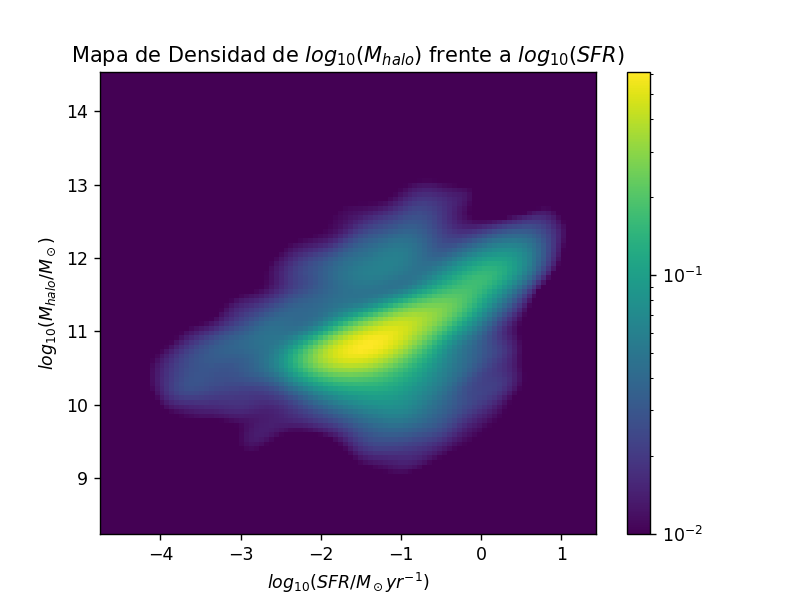

In [56]:
%matplotlib notebook

X = np.array(SFR)
y = np.array(M)

nbins=100
k = kde.gaussian_kde([X,y])
xi, yi = np.mgrid[X.min():X.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.title("Mapa de Densidad de $log_{10}(M_{halo})$ frente a $log_{10}(SFR)$")
plt.xlabel(r"$log_{10}(SFR/M_\odot yr^{-1})$")
plt.ylabel(r"$log_{10}(M_{halo}/M_\odot)$")

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', norm=matplotlib.colors.LogNorm(vmin=10**(-2), vmax=zi.max()))
plt.colorbar()
plt.show()

## Agrupación en Intervalos

In [17]:
median, x_edge, y_edge, _ = scipy.stats.binned_statistic_2d(SM, SFR, M, statistic='max', bins=[SM_BINS, SFR_BINS])
median = np.nan_to_num(median)

In [18]:
X = np.array([])
Y = np.array([])
z = np.array([])
for i in range(SM_BINS):
    for j in range(SFR_BINS):
        if median[i][j] == 0: continue
        X = np.append(X, (x_edge[i]+x_edge[i+1])/2)
        Y = np.append(Y, (y_edge[j]+y_edge[j+1])/2)
        z = np.append(z, median[i][j])

## Gráficas con Intervalos

<IPython.core.display.Javascript object>


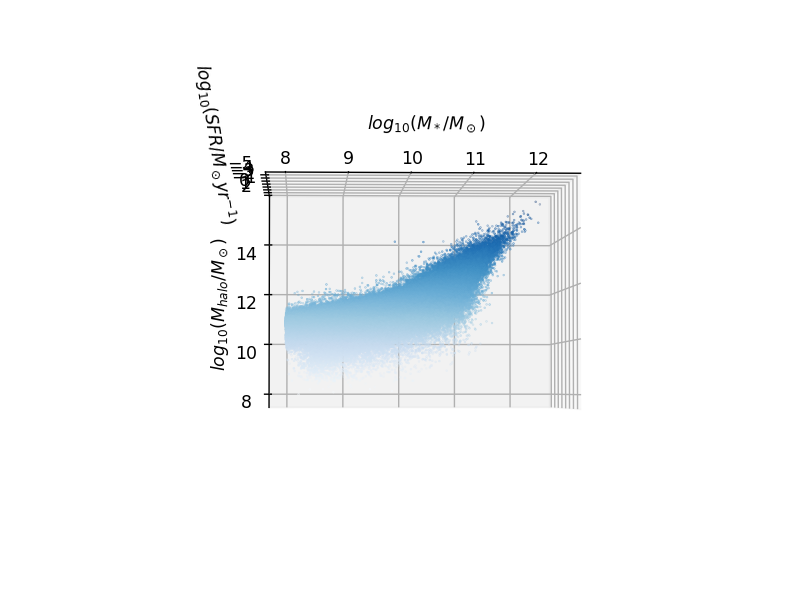

In [52]:
%matplotlib notebook

ax = plt.axes(projection='3d')
ax.set(xlabel='$log_{10}(M_*/M_\odot)$', ylabel='$log_{10}(SFR/M_\odot yr^{-1})$', zlabel='$log_{10}(M_{halo}/M_\odot)$')
ax.scatter3D(X, Y, z, c=z, cmap='Blues', s=0.1);
plt.show()

## *AI-Feynman*

In [13]:
with open(f"data/redshift{Z}.txt", 'w') as f:
        for i in range(len(X)):
            f.write(f"{X[i]} {Y[i]} {z[i]}\n")

In [ ]:
aifeynman.run_aifeynman("./data/", f"redshift{Z}.txt", 21600, ROOT+"aifeynman/ops.txt", polyfit_deg=5)

In [ ]:
%matplotlib notebook

ax = plt.axes(projection='3d')
ax.set(xlabel='$log_{10}(M_*/M_\odot)$', ylabel='$log_{10}(SFR/M_\odot yr^{-1})$', zlabel='$log_{10}(M_{halo}/M_\odot)$')
ax.scatter3D(X, Y, z, c=z, cmap='Blues', s=0.1);

def f(x, y):
    return 8.134471514136+np.exp(np.sqrt(y+np.sqrt(np.exp(x)))/(x-1))

x = np.linspace(7.5, 13, 100)
y = np.linspace(-6, 3, 100)

X_t, Y_t = np.meshgrid(x, y)
Z_t = f(X_t, Y_t)

ax.plot_surface(X_t, Y_t, Z_t, cmap='Reds', antialiased=False)
plt.show()